In [24]:
from IPython.html import widgets
from IPython.display import display
from d3networkx import ForceDirectedGraph, EventfulGraph
import time
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

In [26]:
'''
preparing fake preproc and graphwrap
'''

from graphlearn.processing import PreProcessor
from graphlearn.graph import Wrapper
import graphlearn
class mywrap(Wrapper):
    def clean(self):
        return
    def real_clean(self):
        graphlearn.graph.graph_clean(self._base_graph)

class mypp(PreProcessor):           
    def wrap(self,graph):
        return mywrap(graph,self.vectorizer)
    


In [27]:
%%time
'''
FIRST WE TRAIN A GRAPHSAMPLER
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import graphlearn.utils.interactive as interactive

# setting things up...
training_graphs = gspan_to_eden( '../toolsdata/bursi.pos.gspan' )
training_size=200
training_graphs = itertools.islice(training_graphs,training_size)
sampler=gl.Sampler(radius_list=[0,1], thickness_list=[2],random_state=42447,
                          min_cip_count=2, min_interface_count=2,preprocessor=mypp())
#fitting sampler
sampler.fit(training_graphs)
#sampler.save('tmp/sampler_200.ge')
#loading sampler
#ampler.load('tmp/sampler_200.ge')
interactive.setparameters(sampler)

CPU times: user 3.01 s, sys: 284 ms, total: 3.29 s
Wall time: 5.99 s


In [97]:
import networkx as nx
from graphlearn.utils import draw
from graphlearn import graph as GRAPH

"""MAGIC HAPPENS HERE"""
def transparent_core_substitution(graph,orig_cip_graph,new_cip_graph , CANVAS,SLEEPTIME):

    # GET INTERFACE GRAPHS
    new_graph_interface_nodes = [n for n, d in new_cip_graph.nodes(data=True) if 'core' not in d]
    new_cip_interface_graph = nx.subgraph(new_cip_graph, new_graph_interface_nodes)
    original_graph_interface_nodes = [n for n, d in orig_cip_graph.nodes(data=True) if 'core' not in d]
    original_interface_graph = nx.subgraph(orig_cip_graph, original_graph_interface_nodes)
    # GET ISOMORPHISM
    iso = GRAPH.get_good_isomorphism(graph,
                               orig_cip_graph,
                               new_cip_graph,
                               original_interface_graph,
                               new_cip_interface_graph)
    if len(iso) != len(original_interface_graph):
        print "OH MY GOD"
    
    '''ADDING COLORS'''
    for n, d in new_cip_graph.nodes(data=True):
        if 'core' in d: 
            d['fill']='red'
        else:
            d['fill']='cyan'
            d['color']='back'
    for n, d in orig_cip_graph.nodes(data=True):
        if 'core' in d: 
            graph.node[n]['fill']='red'
        else:
            graph.node[n]['fill']='yellow'
            graph.node[n]['color']='back'
            graph.node[n]['stroke']=3
            
    # MAKE UNION
    graph = nx.union(graph, new_cip_graph, rename=('', '-'))
    '''DRAW UNION'''
    CANVAS.add_nodes_from(graph.nodes(data=True))
    CANVAS.add_edges_from(graph.edges(data=True))
    time.sleep(SLEEPTIME)
    '''DRAW ISOMORPHISM'''
    for k, v in iso.iteritems():
        #graph.node[str(k)]['interface']=True  # i am marking the interface only for the backflow probability calculation in graphlearn, this is probably deleteable because we also do this in merge, also this line is superlong Ooo
        CANVAS.add_edge( str(k), '-' + str(v), distance=200, strokewidth='1px', strength=0.15,stroke='green')
    time.sleep(SLEEPTIME)
    
    
    
    # REMOVE OLD CORE
    original_graph_core_nodes = [n for n, d in orig_cip_graph.nodes(data=True) if 'core' in d]
    for n in original_graph_core_nodes:
        graph.remove_node(str(n))
        CANVAS.remove_node(str(n))
    time.sleep(SLEEPTIME)

        
    #MERGE INTERFACE
    for k, v in iso.iteritems():
        graph.node[str(k)]['interface']=True  # i am marking the interface only for the backflow probability calculation in graphlearn, this is probably deleteable because we also do this in merge, also this line is superlong Ooo
        GRAPH.merge(graph, str(k), '-' + str(v))
        
        for n in CANVAS.neighbors('-' + str(v)):
            CANVAS.add_edge(str(k), n)
        CANVAS.remove_node('-' + str(v))
    time.sleep(SLEEPTIME)
        
          
    # MAKE LABELS INT LABELS
    gr = nx.convert_node_labels_to_integers(graph)
    
    return gr
    


In [101]:
G = EventfulGraph()
d3 = ForceDirectedGraph(G)

# FIXING FORCEDIRECTEDGRAPH ;;; this is a little crappy 
from IPython.utils.traitlets import Unicode, CInt, CFloat 
'''
d3.width = CInt(800, sync=True)
d3.height = CInt(800, sync=True)
d3.charge = CFloat(270., sync=True)
d3.distance = CInt(30., sync=True)
d3.strength = CInt(0.3, sync=True)
'''
d3.width=800
d3.height=800


'''
IF YOU WANT TO LOOK FOR GRAPHS AND CIPS GOTO THE INTERACTIVE AND PICK THERE
'''
#DRAW!
display(d3)

args=interactive.getargz(sampler)
# choose a graph, to start
gr = gspan_to_eden( '../toolsdata/bursi.pos.gspan' )
CURRENT = sampler._sample_init(gr.next())

#choose a node to sub
node_id=19

#choose a cip
cips=interactive.get_cips(CURRENT,sampler,node_id,args)
cip_id=1

graph=CURRENT.base_graph()
orig_cip_graph=cips[cip_id].orig
new_cip_graph=cips[cip_id].graph

graph=draw.contract_edges(graph)
orig_cip_graph=draw.contract_edges(orig_cip_graph)
new_cip_graph=draw.contract_edges(new_cip_graph)
gr = transparent_core_substitution(graph,orig_cip_graph,new_cip_graph, G,3)

#CURRENT=sampler.preprocessor.re_transform_single(gr)
#CURRENT.real_clean()
#draw.graphlearn(CURRENT.base_graph())

In [25]:
print cip_graphs[0].

KeyError: 'info'

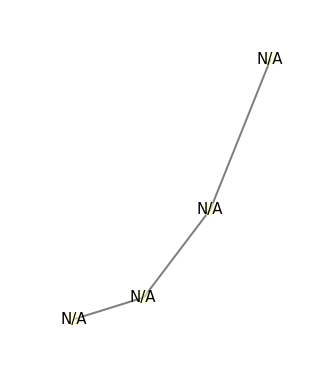

In [19]:

def add(g,f):
    g.add_nodes_from(f.nodes(data=True))
    g.add_edges_from(f.edges(data=True))
    
g=nx.Graph()
f=nx.path_graph(4)
append(g,f)
draw.graphlearn(g)